In [12]:
# After monitoring results for several weeks, it appears that we need flexibility in our application
# The optimal values for trading with a SMA/EMA mean reversion strategy seem to vary day to day, even hour by hour
# which has been realized through incredible returns over buy & hold initially then slowing losing alpha

In [13]:
import numpy as np
import pandas as pd
import yfinance as yf
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
%matplotlib inline

In [22]:
btc = yf.download(tickers='BTC-USD', period='3mo', interval = '1h')

[*********************100%***********************]  1 of 1 completed


In [23]:
btc.reset_index(inplace=True)
btc.rename(columns = {'index':'Date'}, inplace = True)
btc['Date'] = pd.to_datetime(btc['Date'])
btc.set_index('Date')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-10 19:00:00+00:00,38101.281250,38493.589844,37507.855469,37507.855469,37507.855469,0
2021-01-10 20:00:00+00:00,37553.093750,37639.363281,35984.628906,37618.878906,37618.878906,5882241024
2021-01-10 21:00:00+00:00,37784.140625,38166.925781,37734.562500,37974.167969,37974.167969,2130837504
2021-01-10 22:00:00+00:00,38078.976562,38966.371094,38013.855469,38568.125000,38568.125000,1718910976
2021-01-10 23:00:00+00:00,38528.371094,38680.671875,38119.562500,38374.152344,38374.152344,165740544
...,...,...,...,...,...,...
2021-04-10 16:00:00+01:00,60471.566406,60521.781250,60197.984375,60360.710938,60360.710938,182714368
2021-04-10 17:00:00+01:00,60350.859375,60578.058594,60246.253906,60251.000000,60251.000000,1026674688
2021-04-10 18:00:00+01:00,60317.113281,60320.503906,60100.824219,60156.687500,60156.687500,1041108992


In [24]:
# Function to return the SMA
def SMA(values, n):
    return pd.Series(values).rolling(n).mean()
class SmaCross(Strategy):
    # Placeholder for calculations
    ma_short = 10
    ma_long = 20
    df = btc
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.df.Close.to_numpy(), self.ma_short)
        self.sma2 = self.I(SMA, self.df.Close.to_numpy(), self.ma_long)
    
    def next(self):
        # If sma1 crosses above sma2 buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()
        # Else, if sma1 crosses below sma2 sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()

In [25]:
# reminder that we use this Backtest class
bt = Backtest(data=btc, strategy=SmaCross, cash=100000, commission=.002)
# evaluate all possible combinations
stats, heatmap = bt.optimize(
    ma_short=range(0, 168, 2),
    ma_long=range(120, 336, 2),
    constraint=lambda p: p.ma_short < p.ma_long,
    maximize='Equity Final [$]',
    return_heatmap=True)
# check the top 10 returns
heatmap.sort_values(ascending=False).iloc[:10]

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  
/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/backtesting/backtesting.py:1472: UserWarning: Searching for best of 8772 configurations.
  output = _optimize_grid()


ma_short  ma_long
142       150        187075.266336
140       178        184870.497602
124       194        184768.227836
140       180        184079.767340
142       176        182303.558125
          178        182223.670750
122       194        182142.412703
126       192        181330.405188
138       180        180196.067805
142       148        180020.075449
Name: Equity Final [$], dtype: float64

<AxesSubplot:xlabel='ma_long', ylabel='ma_short'>

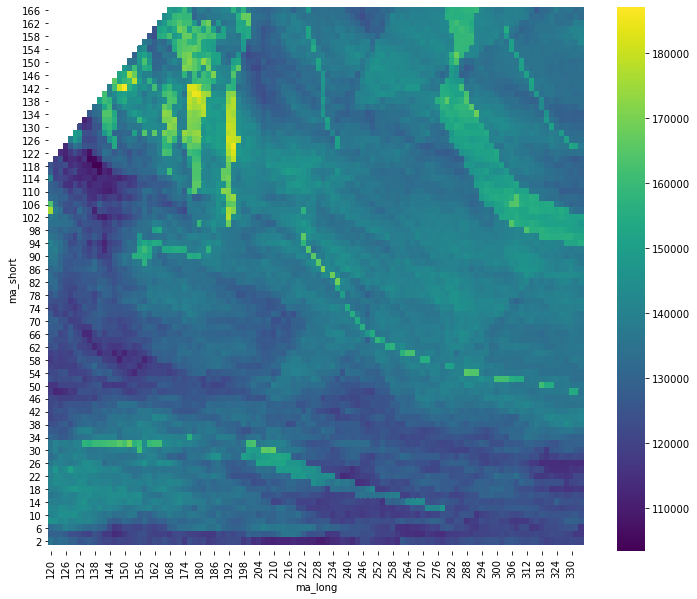

In [26]:
# group 
hm = heatmap.groupby(['ma_short', 'ma_long']).mean().unstack()
#plot heatmap
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(hm[::-1], cmap='viridis')

In [27]:
# After running the optimizer several times, it appears that because of the votality behind BTC
# the SMA should be optimized every so often to ensure the best results

In [28]:
from backtesting import Strategy
from backtesting.lib import crossover
class SmaCross_short_long(Strategy):
    # Define the two MA lags as *class variables*
    ma_short = 142
    ma_long = 150
    df = btc
    
    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.df.Close.to_numpy(), self.ma_short)
        self.sma2 = self.I(SMA, self.df.Close.to_numpy(), self.ma_long)
    
    def next(self):
        # If sma1 crosses above sma2 buy the asset
        if crossover(self.sma1, self.sma2):
            self.buy()
# Else, if sma1 crosses below sma2 sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()

# run the backtest
bt = Backtest(data=btc, strategy=SmaCross_short_long, cash=100000, commission=.002)
bt.run()
# plot the trades
bt.plot()

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.


In [21]:
bt = Backtest(data=btc, strategy=SmaCross_short_long, cash=100000, commission=.002)
bt.run()

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  """Entry point for launching an IPython kernel.


Start                                       0
End                                      2390
Duration                                 2390
Exposure Time [%]                     55.2907
Equity Final [$]                       187075
Equity Peak [$]                        187922
Return [%]                            87.0753
Buy & Hold Return [%]                 105.054
Return (Ann.) [%]                         NaN
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                    -20.7724
Avg. Drawdown [%]                    -2.76587
Max. Drawdown Duration                    656
Avg. Drawdown Duration                45.1395
# Trades                                   18
Win Rate [%]                          61.1111
Best Trade [%]                        35.2367
Worst Trade [%]                      -9.39284
Avg. Trade [%]                    

In [ ]:
# Results seem to vary quite frequently for SMA, so let's move to EMA to see what timeframe we should be trading off of
# EMA will most likely be more stable because it's the exponential, so it will be placing higher weight on more frequent changes
# Therefore, it's less likely to be reactive towards ebbs and flows in market that could affect ema short and long ranges

In [6]:
# Function to return the EMA
def EMA(values, n):
    return pd.Series.ewm(values, span=n).mean()
class EmaCross(Strategy):
    ma_short = 10
    ma_long = 20
    df = btc
    
    def init(self):
        # Precompute the two moving averages
        self.ema1 = self.I(EMA, self.df.Close, self.ma_short)
        self.ema2 = self.I(EMA, self.df.Close, self.ma_long)
    
    def next(self):
        # If ema1 crosses above ema2 buy the asset
        if crossover(self.ema1, self.ema2):
            self.buy()
        # Else, if ema1 crosses below ema2 sell the asset
        elif crossover(self.ema2, self.ema1):
            self.position.close()

In [11]:
# reminder that we use this Backtest class
bt = Backtest(data=btc, strategy=EmaCross, cash=100000, commission=.002)
# evaluate all possible combinations
stats, heatmap = bt.optimize(
    ma_short=range(1, 168, 2),
    ma_long=range(168, 336, 2),
    constraint=lambda p: p.ma_short < p.ma_long,
    maximize='Equity Final [$]',
    return_heatmap=True)
# check the top 10 returns
heatmap.sort_values(ascending=False).iloc[:10]

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  
/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/backtesting/backtesting.py:1472: UserWarning: Searching for best of 7056 configurations.
  output = _optimize_grid()


ma_short  ma_long
165       224        168525.667633
167       222        168525.667633
161       232        167070.327789
165       226        167070.327789
167       224        167070.327789
159       234        167070.327789
163       230        167070.327789
161       234        166870.409617
165       230        166870.409617
163       232        166870.409617
Name: Equity Final [$], dtype: float64

In [ ]:
# group 
hm = heatmap.groupby(['ma_short', 'ma_long']).mean().unstack()
#plot heatmap
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 10))
sns.heatmap(hm[::-1], cmap='viridis')

In [8]:
class EmaCross_short_long(Strategy):
    # Define the two MA lags as *class variables*
    ma_short = 166
    ma_long = 222
    df = btc
    
    def init(self):
        # Precompute the two moving averages
        self.ema1 = self.I(EMA, self.df.Close, self.ma_short)
        self.ema2 = self.I(EMA, self.df.Close, self.ma_long)
    
    def next(self):
        # If sma1 crosses above sma2 buy the asset
        if crossover(self.ema1, self.ema2):
            self.buy()
# Else, if sma1 crosses below sma2 sell the asset
        elif crossover(self.ema2, self.ema1):
            self.position.close()

# run the backtest
bt = Backtest(data=btc, strategy=EmaCross_short_long, cash=100000, commission=.002)
bt.run()
# plot the trades
bt.plot()

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.


In [9]:
# run the backtest
bt = Backtest(data=btc, strategy=EmaCross_short_long, cash=100000, commission=.002)
bt.run()

/Users/madisonleopold/opt/anaconda3/envs/PythonCrypto/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  


Start                                       0
End                                      2389
Duration                                 2389
Exposure Time [%]                     72.5523
Equity Final [$]                       167403
Equity Peak [$]                        185652
Return [%]                            67.4028
Buy & Hold Return [%]                 106.326
Return (Ann.) [%]                         NaN
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                    -21.8996
Avg. Drawdown [%]                    -3.60658
Max. Drawdown Duration                    740
Avg. Drawdown Duration                66.7429
# Trades                                    5
Win Rate [%]                               80
Best Trade [%]                        35.3133
Worst Trade [%]                      -3.69678
Avg. Trade [%]                    

In [ ]:
#SMA_3 = pd.Series(btc.Close).rolling(3).mean()

In [ ]:
#SMA_66 = pd.Series(btc.Close).rolling(66).mean()

In [ ]:
EMA_6 = pd.Series.ewm(btc.Close, span=6).mean()
EMA_52 = pd.Series.ewm(btc.Close, span=52).mean()

In [ ]:
btc_close = btc[['Date', 'Close']]
btc_close

In [ ]:
#SMA_27 = pd.Series(btc.Close).rolling(27).mean()
#SMA_50 = pd.Series(btc.Close).rolling(50).mean()

In [ ]:
#btc_close['SMA_27'] = SMA_27
#btc_close['SMA_50'] = SMA_50

In [ ]:
#btc_close['SMA_3'] = SMA_3
#btc_close['SMA_66'] = SMA_66

btc_close['EMA_6'] = EMA_6
btc_close['EMA_52'] = EMA_52

In [ ]:
btc_close

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(btc_close['Date'], btc_close['Close'], label='Closing Price')
plt.plot(btc_close['Date'], btc_close['EMA_6'], label='EMA_6')
plt.plot(btc_close['Date'], btc_close['EMA_52'], label='EMA_52')
plt.legend()
plt.show()

In [ ]:
delta = btc['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
ema_up = up.ewm(com=13, adjust=False).mean()
ema_down = down.ewm(com=13, adjust=False).mean()
rs = ema_up/ema_down

In [ ]:
rs

In [ ]:
btc_close['RSI'] = 100 - (100/(1 + rs))

btc_close

In [ ]:
exp1 = btc[['Date', 'Close']].ewm(span=12, adjust=False).mean()
exp2 = btc[['Date', 'Close']].ewm(span=26, adjust=False).mean()
macd = exp1 - exp2
exp3 = macd.ewm(span=9, adjust=False).mean()

In [ ]:
btc_close['MACD'] = macd
btc_close['Signal'] = exp3

In [ ]:
btc_close.head(60)

In [ ]:
btc_close['Trend'] = 0
for index, row in btc_close.iterrows():
    try:
        prev_signal = btc_close.at[index - 1, 'Signal']
        current_signal = btc_close.at[index, 'Signal']
        if index == 0 or index == 1:
            continue
        else:
            if prev_signal > current_signal:
                btc_close.at[index, 'Trend'] = -1
            else:
                btc_close.at[index, 'Trend'] = 1
    except:
        pass

In [ ]:
btc_close.head(50)

In [ ]:
btc_close['Buy/Sell'] = ""
for index, row in btc_close.iterrows():
    try:
        current_trend = btc_close.at[index, 'Trend']
        prev_trend = btc_close.at[index - 1, 'Trend']
        #SMA_3 = btc_close.at[index, 'SMA_3']
        #SMA_66 = btc_close.at[index, 'SMA_66']
        #isNaN_prev = np.isnan(prev_trend)
        #isNaN_current = np.isnan(current_trend)
        if prev_trend == 0 or current_trend == 0:
            pass
        elif prev_trend != current_trend:
            print("Trend different")
            print(f"{prev_trend} and {current_trend}")
            if prev_trend == -1:
                btc_close.at[index, 'Buy/Sell'] = 'Buy'
            else:
                btc_close.at[index, 'Buy/Sell'] = 'Sell'
        else:
            continue
    except:
        pass

In [ ]:
btc_close['Cross'] = ""
for index, row in btc_close.iterrows():
    try:
        #current_trend = btc_close.at[index, 'Trend']
        #prev_trend = btc_close.at[index - 1, 'Trend']
        curr_short_EMA = btc_close.at[index, 'EMA_6']
        curr_long_EMA = btc_close.at[index, 'EMA_52']
        prev_short_EMA = btc_close.at[index - 1, 'EMA_6']
        prev_long_EMA = btc_close.at[index - 1, 'EMA_52']
        curr_isNaN_short = np.isnan(curr_short_EMA)
        curr_isNaN_long = np.isnan(curr_long_EMA)
        prev_isNaN_short = np.isnan(prev_short_EMA)
        prev_isNaN_long = np.isnan(prev_long_EMA)
        if curr_isNaN_short == True or curr_isNaN_long == True or prev_isNaN_short == True or prev_isNaN_long == True:
            pass
        else:
            if prev_short_EMA < prev_long_EMA and curr_short_EMA > curr_long_EMA:
                btc_close.at[index, 'Cross'] = 'Bull Cross'
            elif prev_short_EMA > prev_long_EMA and curr_short_EMA < curr_long_EMA:
                btc_close.at[index, 'Cross'] = 'Bear Cross'
            else:
                continue
    except:
        pass

In [ ]:
btc_close.head(60)

In [ ]:
btc_close = btc_close[['Date', 'Close', 'EMA_6', 'EMA_52', 'RSI', 'MACD', 'Signal', 'Trend', 'Buy/Sell', 'Cross']]

In [ ]:
btc_close['Above/Below Short EMA'] = ""
for index, row in btc_close.iterrows():
    try:
        #current_trend = btc_close.at[index, 'Trend']
        #prev_trend = btc_close.at[index - 1, 'Trend']
        short_EMA = btc_close.at[index, 'EMA_6']
        long_EMA = btc_close.at[index, 'EMA_52']
        close_price = btc_close.at[index, 'Close']
        if close_price < short_EMA:
            btc_close.at[index, 'Above/Below Short EMA'] = 'Below Short EMA'
        else:
            btc_close.at[index, 'Above/Below Short EMA'] = 'Above Short EMA'  
    except:
        pass

In [ ]:
btc_close['Above/Below Long EMA'] = ""
for index, row in btc_close.iterrows():
    try:
        #current_trend = btc_close.at[index, 'Trend']
        #prev_trend = btc_close.at[index - 1, 'Trend']
        short_EMA = btc_close.at[index, 'EMA_6']
        long_EMA = btc_close.at[index, 'EMA_52']
        close_price = btc_close.at[index, 'Close']
        if close_price < long_EMA:
            btc_close.at[index, 'Above/Below Long EMA'] = 'Below Long EMA'
        else:
            btc_close.at[index, 'Above/Below Long EMA'] = 'Above Long EMA' 
    except:
        pass

In [ ]:
btc_close.head(50)

In [ ]:
# Due to results - it may be beneficial to tighten the period width to ensure more accurate results
# Buy indicators are occuring after crosses, so potentially tightening period could help line up indicators
# Additionally, prices fluctuate above and below EMA frequently, so tightening periods could help identify best time to buy or sell if another signal is present

In [ ]:
#rolling_mean = btc_close['Close'].rolling(3).mean()
#rolling_std = btc_close['Close'].rolling(3).std()

In [ ]:
#btc_close['Bollinger High'] = rolling_mean + (rolling_std * 1)
#btc_close['Bollinger Low'] = rolling_mean - (rolling_std * 1)     

In [ ]:
#btc_close.head(50)

In [ ]:
#btc_close.loc[btc_close['Buy/Sell'] != ''].head(20)

In [ ]:
#btc_close.loc[(btc_close['Buy/Sell'] == 'Buy') & (btc_close['SMA_3'] >= btc_close['SMA_66'])]

In [ ]:
btc = yf.download(tickers='BTC-USD', period = '3mo', interval = '1h')

In [ ]:
# Function to return the EMA
def EMA(values, n):
    return pd.Series.ewm(values, span=n).mean()
class EmaCross(Strategy):
    ma_short = 10
    ma_long = 20
    df = btc
    
    def init(self):
        # Precompute the two moving averages
        self.ema1 = self.I(EMA, self.df.Close, self.ma_short)
        self.ema2 = self.I(EMA, self.df.Close, self.ma_long)
    
    def next(self):
        # If ema1 crosses above ema2 buy the asset
        if crossover(self.ema1, self.ema2):
            self.buy()
        # Else, if ema1 crosses below ema2 sell the asset
        elif crossover(self.ema2, self.ema1):
            self.position.close()

In [ ]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
class EmaCross_6_52(Strategy):
    # Define the two MA lags as *class variables*
    ma_short = 6
    ma_long = 52
    df = btc
    
    def init(self):
        # Precompute the two moving averages
        self.ema1 = self.I(EMA, self.df.Close, self.ma_short)
        self.ema2 = self.I(EMA, self.df.Close, self.ma_long)
    
    def next(self):
        # If sma1 crosses above sma2 buy the asset
        if crossover(self.ema1, self.ema2):
            self.buy()
# Else, if sma1 crosses below sma2 sell the asset
        elif crossover(self.ema2, self.ema1):
            self.position.close()

# run the backtest
bt = Backtest(data=btc, strategy=EmaCross_6_52, cash=100000, commission=.002)
bt.run()
# plot the trades
bt.plot()

In [ ]:
# run the backtest
bt = Backtest(data=btc, strategy=EmaCross_6_52, cash=100000, commission=.002)
bt.run()

In [ ]:
btc

In [ ]:
btc.set_index('Date')

In [ ]:
#  we are going to test a basic moving average crossover system based on a 
# 20-day Exponential Moving Average (EMA) and a 200-day Simple Moving Average (SMA) 
# of the daily closing price (using Adjusted Close in this example). We are going to buy the stock 
# (take a long position) whenever the 20-day EMA crosses the 200-day SMA from below.

In [ ]:
df = btc.copy()
sma_span = 200
ema_span = 20
df['sma200'] = df['Adj Close'].rolling(sma_span).mean()
df['ema20'] = df['Adj Close'].ewm(span=ema_span).mean()
df.round(3)

In [ ]:
df.dropna(inplace=True)
df.round(3)

In [ ]:
def plot_system1(data):
    df = data.copy()
    dates = df.index
    price = df['Adj Close']
    sma200 = df['sma200']
    ema20 = df['ema20']
    
    with plt.style.context('fivethirtyeight'):
        fig = plt.figure(figsize=(14,7))
        plt.plot(dates, price, linewidth=1.5, label='CPB price - Daily Adj Close')
        plt.plot(dates, sma200, linewidth=2, label='200 SMA')
        plt.plot(dates, ema20, linewidth=2, label='20 EMA')
        plt.title("A Simple Crossover System")
        plt.ylabel('Price($)')
        plt.legend()
    
    plt.show()

In [ ]:
plot_system1(df)

In [ ]:
# Our trading condition:
long_positions = np.where(df['ema20'] > df['sma200'], 1, 0)
df['Position'] = long_positions
df.round(3)

In [ ]:
df.head()

In [ ]:
buy_signals = (df['Position'] == 1) & (df['Position'].shift(1) == 0)
df.loc[buy_signals].round(3)

In [ ]:
buy_signals_prev = (df['Position'].shift(-1) == 1) & (df['Position'] == 0)
df.loc[buy_signals | buy_signals_prev].round(3)

In [ ]:
def plot_system1_sig(data):
    df = data.copy()
    dates = df.index
    price = df['Adj Close']
    sma200 = df['sma200']
    ema20 = df['ema20']
    
    buy_signals = (df['Position'] == 1) & (df['Position'].shift(1) == 0)
    buy_marker = sma200 * buy_signals - (sma200.max()*.05)
    buy_marker = buy_marker[buy_signals]
    buy_dates = df.index[buy_signals]
    sell_signals = (df['Position'] == 0) & (df['Position'].shift(1) == 1)
    sell_marker = sma200 * sell_signals + (sma200.max()*.05)
    sell_marker = sell_marker[sell_signals]
    sell_dates = df.index[sell_signals]
    
    with plt.style.context('fivethirtyeight'):
        fig = plt.figure(figsize=(14,7))
        plt.plot(dates, price, linewidth=1.5, label='CPB price - Daily Adj Close')
        plt.plot(dates, sma200, linewidth=2, label='200 SMA')
        plt.plot(dates, ema20, linewidth=2, label='20 EMA')
        plt.scatter(buy_dates, buy_marker, marker='^', color='green', s=160, label='Buy')
        plt.scatter(sell_dates, sell_marker, marker='v', color='red', s=160, label='Sell')
        plt.title("A Simple Crossover System with Signals")
        plt.ylabel('Price($)')
        plt.legend()
    
    plt.show()

In [ ]:
plot_system1_sig(df)

In [ ]:
# The returns of the Buy and Hold strategy:
df['Hold'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
# The returns of the Moving Average strategy:
df['Strategy'] = df['Position'].shift(1) * df['Hold']
# We need to get rid of the NaN generated in the first row:
df.dropna(inplace=True)
df

In [ ]:
returns = np.exp(df[['Hold', 'Strategy']].sum()) - 1
print(f"Buy and hold return: {round(returns['Hold']*100,2)}%")
print(f"Strategy return: {round(returns['Strategy']*100,2)}%")